In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow.keras import layers
from tensorflow import keras
from helper_functions.scan_helper_functions_configs_MP import *
from helper_functions.MIE_NN.MieTFNew import PINNLossFunctionP11
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
#from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

2022-04-23 18:34:33.667567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/user/ponts_m/pythonenv/lib:
2022-04-23 18:34:33.667628: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-23 18:35:04.442205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/user/ponts_m/pythonenv/lib:
2022-04-23 18:35:04.442294: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 18:35:04.442339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (merlin-c-101.psi.c

# Looking at the training history

### Reading in the training- and validation data

In [2]:
train_datafile = '/data/user/ponts_m/DataSets/GODataSet/DS10000_532nm_GO_scaled.h5'

dvar_train_wo_scaling, dvar_val_wo_scaling, qoi_train_wo_scaling, qoi_val_wo_scaling = load_dataset_wo_split(train_datafile)

dvar_train = dvar_train_wo_scaling
dvar_val = dvar_val_wo_scaling

qoi_train = qoi_train_wo_scaling
qoi_val = qoi_val_wo_scaling

n_in = dvar_train.shape[1]
n_out = qoi_train.shape[1]

### Model directories for the normal NN and the physics informed NN

In [25]:
model_name_nn = 'forward_model_nn'
model_name_pinn = 'forward_model_pinn'
model_dir = '/data/project/general/aerosolretriev/aerosol_results_mp/TransferLearningGPU/Set12/'

### Load both models

In [26]:

custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
    'AdjustedRSquared_custom': AdjustedRSquared_custom,
    'custom_loss': custom_loss_wrapper,
}

kwargs = {
    'custom_objects': custom_objects,
}

final_model_nn = keras.models.load_model(f'{model_dir}/forward_model_nn')
final_model_pinn = keras.models.load_model(f'{model_dir}/forward_model_pinn', custom_objects=custom_objects)

### Load the training history and the metrics which were already calculated and saved after training when running the transfer learning script

In [27]:
with open(f'{model_dir}/nn_history.pkl', 'rb') as a:
    nn_history = pickle.load(a)
        
with open(f'{model_dir}/pinn_history_history.pkl', 'rb') as b:
    pinn_history = pickle.load(b)
        
with open(f'{model_dir}/metrics_train_nn.pkl', 'rb') as c:
    metrics_train_nn = pickle.load(c)
        
with open(f'{model_dir}/metrics_train_pinn.pkl', 'rb') as d:
    metrics_train_pinn = pickle.load(d)
        
with open(f'{model_dir}/metrics_val_nn.pkl', 'rb') as e:
    metrics_val_nn = pickle.load(e)
        
with open(f'{model_dir}/metrics_val_pinn.pkl', 'rb') as f:
    metrics_val_pinn = pickle.load(f)
    
with open(f'{model_dir}/metrics_train_abs_pinn.pkl', 'rb') as g:
    metrics_train_abs_pinn = pickle.load(g)
    
with open(f'{model_dir}/metrics_val_abs_pinn.pkl', 'rb') as h:
    metrics_val_abs_pinn = pickle.load(h)

### Printing the training history keys and reading in the loss and validation loss for plotting below

In [28]:
print(nn_history.history.keys())
loss_nn = nn_history.history['loss']
val_loss_nn = nn_history.history['val_loss']

print(pinn_history.keys())
loss_pinn = pinn_history['loss']
val_loss_pinn = pinn_history['val_loss']

dict_keys(['loss', 'MAE', 'MAPE', 'val_loss', 'val_MAE', 'val_MAPE'])
dict_keys(['loss', 'adjusted_r2', 'val_loss', 'val_adjusted_r2'])


### Plotting the loss and the validation loss versus the epochs for both the normal NN and the physics informed NN

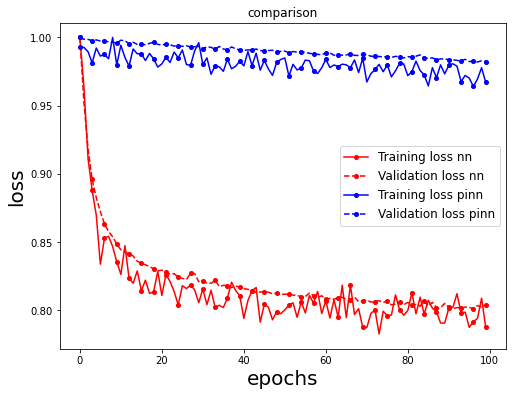

In [29]:
'''
#train and validation loss for the normal nn
plt.figure(figsize = (8,6))
plt.plot(loss_nn, label = 'Training loss nn')
plt.plot(val_loss_nn, label = 'Validation loss nn')
plt.legend(fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epochs', fontsize = 20)
plt.title('nn')

#train and validation loss for the physics informed nn
plt.figure(figsize = (8,6))
plt.plot(loss_pinn, label = 'Training loss pinn')
plt.plot(val_loss_pinn, label = 'Validation loss pinn')
plt.legend(fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epochs', fontsize = 20)
plt.title('pinn')
'''

#train and validation loss - normalized - for normal and physics informed nn
plt.figure(figsize = (8,6))
plt.plot(loss_nn/np.max(loss_nn), linestyle='-', marker='o',ms=4,markevery=3, label = 'Training loss nn', color='red')
plt.plot(val_loss_nn/np.max(val_loss_nn), linestyle='--',marker='o',ms=4,markevery=3, label = 'Validation loss nn', color='red')
plt.plot(loss_pinn/np.max(loss_pinn), linestyle='-',marker='o',ms=4,markevery=3, label = 'Training loss pinn', color='blue')
plt.plot(val_loss_pinn/np.max(val_loss_pinn), linestyle='--',marker='o',ms=4,markevery=3, label = 'Validation loss pinn', color='blue')
plt.legend(fontsize = 12)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epochs', fontsize = 20)
plt.title('comparison')
plt.savefig('losscomparison.svg')

### Looking at the metrics

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

 $ {\displaystyle {\mbox{WMAPE}}={\frac {\sum _{t=1}^{n}\left|A_{t}-F_{t}\right|}{\sum _{t=1}^{n}\left|A_{t}\right|}}}$

where A is a vector of the actual data and F is the forecast. The advantage of this metric over MAPE is that this overcomes the 'infinite error' issue

In [30]:
print('Training metrics for the normal NN:')
metrics_train_nn

Training metrics for the normal NN:


{'MAE': 11.36385706796377,
 'MAPE': 5.33898094539492,
 'MSE': 1325.6793501790266,
 'wmape': 1.4941440546914886,
 'median_percentile_max_error': 4.557278867749291,
 '90_percentile_max_error': 22.789643970065153,
 'r2': 0.9781540021888805,
 'r2_adj': 0.977658839038516}

In [31]:
print('Validation metrics for the normal NN:')
metrics_val_nn

Validation metrics for the normal NN:


{'MAE': 12.563797761380043,
 'MAPE': 5.582082332696202,
 'MSE': 1895.1090539285403,
 'wmape': 1.645489651591953,
 'median_percentile_max_error': 4.485151817498699,
 '90_percentile_max_error': 23.09537341581911,
 'r2': 0.9566625731618398,
 'r2_adj': 0.9523890741713625}

In [32]:
print('Training metrics for the PINN:')
metrics_train_pinn

Training metrics for the PINN:


{'MAE': 11.36385706796377,
 'MAPE': 5.33898094539492,
 'MSE': 1325.6793501790266,
 'wmape': 1.4941440546914886,
 'median_percentile_max_error': 4.557278867749291,
 '90_percentile_max_error': 22.789643970065153,
 'r2': 0.9781540021888805,
 'r2_adj': 0.977658839038516}

In [33]:
print('Validation metrics for the PINN:')
metrics_val_pinn

Validation metrics for the PINN:


{'MAE': 12.563797761380043,
 'MAPE': 5.582082332696202,
 'MSE': 1895.1090539285403,
 'wmape': 1.645489651591953,
 'median_percentile_max_error': 4.485151817498699,
 '90_percentile_max_error': 23.09537341581911,
 'r2': 0.9566625731618398,
 'r2_adj': 0.9523890741713625}

### Printing the difference between normal NN metrics and physics informed NN metrics. Positive numbers are 'good' because that means the physics informed NN is winning ;)

In [34]:
print('Normal NN metrics - Physics Informed NN metrics (Training): \n')
for key in metrics_train_nn:
    print(key, metrics_train_nn[key]-metrics_train_pinn[key])

print('\n')
    
print('Normal NN metrics - Physics Informed NN metrics (Validation): \n')
for key in metrics_val_nn:
    print(key, metrics_val_nn[key]-metrics_val_pinn[key])

Normal NN metrics - Physics Informed NN metrics (Training): 

MAE 0.0
MAPE 0.0
MSE 0.0
wmape 0.0
median_percentile_max_error 0.0
90_percentile_max_error 0.0
r2 0.0
r2_adj 0.0


Normal NN metrics - Physics Informed NN metrics (Validation): 

MAE 0.0
MAPE 0.0
MSE 0.0
wmape 0.0
median_percentile_max_error 0.0
90_percentile_max_error 0.0
r2 0.0
r2_adj 0.0


# Test performances of the new neural networks

### Read in Test Data and Preprocess it

In [35]:
def scaling(data):
    return (data - np.min(data))/(np.max(data)-np.min(data))

def inverse_scaling(data, xmax, xmin):
    return data*(xmax-xmin)+xmin

In [36]:
test_datafile = '/data/user/ponts_m/DataSets/GODataSet/DSTest20000_532nm_GO.h5'

dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
n_in = dvar_test.shape[1]

dvar_max = np.max(dvar_test).to_numpy()
dvar_min = np.min(dvar_test).to_numpy()
qoi_max = np.max(qoi_test).to_numpy()
qoi_min = np.min(qoi_test).to_numpy()

dvar_test_scaled = scaling(dvar_test)
qoi_test_scaled = scaling(qoi_test)

### Predict Test Data and Inverse Preprocess it

In [37]:
qoi_pred_test_nn_scaled = final_model_nn.predict(dvar_test_scaled)
qoi_pred_test_pinn_scaled = final_model_pinn.predict(dvar_test_scaled)[:,-5:]

In [38]:
qoi_pred_test_nn = inverse_scaling(qoi_pred_test_nn_scaled, qoi_max, qoi_min)
qoi_pred_test_pinn = inverse_scaling(qoi_pred_test_pinn_scaled, qoi_max, qoi_min)

### Calculate Metrics

In [39]:
metrics_test_nn = calculate_metrics_custom(qoi_test, qoi_pred_test_nn, n_in)
metrics_test_pinn = calculate_metrics_custom(qoi_test, np.abs(qoi_pred_test_pinn), n_in)

### Look at metrics of the normal NN for every aerosol parameter separately

In [40]:
print('Normal NN metrics: \n')
for key in metrics_test_nn:
    print(key,'\n', metrics_test_nn[key], '\n')

Normal NN metrics: 

MAE 
 RealRefractiveIndex           0.022059
ImaginaryRefractiveIndex      0.020507
Sigma                         0.019429
MeanRadius                   77.360972
VolumeConcentration         112.211332
dtype: float64 

MAPE 
 RealRefractiveIndex          1.508605
ImaginaryRefractiveIndex    42.693804
Sigma                        1.364472
MeanRadius                   7.783627
VolumeConcentration         23.405835
dtype: float64 

MSE 
 RealRefractiveIndex             0.000738
ImaginaryRefractiveIndex        0.000951
Sigma                           0.000545
MeanRadius                   6736.218851
VolumeConcentration         27041.757317
dtype: float64 

wmape 
 RealRefractiveIndex          1.505828
ImaginaryRefractiveIndex    20.462030
Sigma                        1.363609
MeanRadius                   5.825473
VolumeConcentration          4.509547
dtype: float64 

median_percentile_max_error 
 16.20444158479782 

90_percentile_max_error 
 59.13383756889519 

r2 
 0.3

### Look at metrics of the physics informed NN for every aerosol parameter separately

In [41]:
print('Physics Informed NN metrics: \n')
for key in metrics_test_nn:
    print(key,'\n', metrics_test_pinn[key], '\n')

Physics Informed NN metrics: 

MAE 
 RealRefractiveIndex           0.022059
ImaginaryRefractiveIndex      0.020393
Sigma                         0.019429
MeanRadius                   77.360972
VolumeConcentration         111.493158
dtype: float64 

MAPE 
 RealRefractiveIndex          1.508605
ImaginaryRefractiveIndex    39.958178
Sigma                        1.364472
MeanRadius                   7.783627
VolumeConcentration         21.632700
dtype: float64 

MSE 
 RealRefractiveIndex             0.000738
ImaginaryRefractiveIndex        0.000948
Sigma                           0.000545
MeanRadius                   6736.218851
VolumeConcentration         26852.738376
dtype: float64 

wmape 
 RealRefractiveIndex          1.505828
ImaginaryRefractiveIndex    20.347731
Sigma                        1.363609
MeanRadius                   5.825473
VolumeConcentration          4.480685
dtype: float64 

median_percentile_max_error 
 16.159402886597874 

90_percentile_max_error 
 56.81632197545210

### Look at difference of the metrics

In [42]:
print('Normal NN metrics - Physics Informed NN metrics (Testing): \n')
for key in metrics_test_nn:
    print(key,'\n', metrics_test_nn[key]-metrics_test_pinn[key], '\n')

Normal NN metrics - Physics Informed NN metrics (Testing): 

MAE 
 RealRefractiveIndex         0.000000
ImaginaryRefractiveIndex    0.000115
Sigma                       0.000000
MeanRadius                  0.000000
VolumeConcentration         0.718173
dtype: float64 

MAPE 
 RealRefractiveIndex         0.000000
ImaginaryRefractiveIndex    2.735626
Sigma                       0.000000
MeanRadius                  0.000000
VolumeConcentration         1.773135
dtype: float64 

MSE 
 RealRefractiveIndex           0.000000
ImaginaryRefractiveIndex      0.000003
Sigma                         0.000000
MeanRadius                    0.000000
VolumeConcentration         189.018941
dtype: float64 

wmape 
 RealRefractiveIndex         0.000000
ImaginaryRefractiveIndex    0.114298
Sigma                       0.000000
MeanRadius                  0.000000
VolumeConcentration         0.028862
dtype: float64 

median_percentile_max_error 
 0.04503869819994577 

90_percentile_max_error 
 2.31751559344308